# Environment

In [1]:
rm -r output/

In [2]:
import os
import gc
import ray
import json
import numpy as np
import pandas as pd
import seaborn as sns

from pathlib import Path
from src.utils import *

# K-mers
from src.data.seq_collections import SeqCollection
from src.data.kmers_collection import KmersCollection

# Preprocessing
from src.models.kerasTF.ray_one_hot_tensor import OneHotTensorEncoder
from ray.data.preprocessors import Chain, LabelEncoder
from src.models.ray_tensor_min_max import TensorMinMaxScaler
from src.models.sklearn.ray_sklearn_onesvm_encoder import OneClassSVMLabelEncoder

# Training
import tensorflow as tf
from ray.air import session
from sklearn.linear_model import SGDOneClassSVM
from ray.air.integrations.keras import Callback
from src.models.kerasTF.build_neural_networks import *
from src.models.sklearn.ray_sklearn_partial_trainer import SklearnPartialTrainer
from ray.train.tensorflow import TensorflowTrainer, TensorflowCheckpoint, prepare_dataset_shard

# Tuning
from ray.air.config import RunConfig, ScalingConfig, DatasetConfig

# Predicting
from ray.train.sklearn import SklearnPredictor
from ray.train.tensorflow import TensorflowPredictor
from ray.train.batch_predictor import BatchPredictor
from joblib import Parallel, delayed, parallel_backend

# Simulation
from src.models.reads_simulation import readsSimulation


# Parameters / global variables

### Definition

In [3]:
# Names
db_name = '30_genomes'
host_name = 'cucurbita_3'
metagenome_name = 'metagenome'
# IO
db_fasta = 'example_data/30_genomes.fna.gz'
db_cls = 'example_data/30_genomes.csv'
host_fasta = 'example_data/cucurbita_sample_3.fna.gz'
host_cls = 'example_data/cucurbita_sample_3.csv'
metagenome_fasta = 'example_data/metagenome.fna.gz'
metagenome_cls = 'example_data/metagenome.csv'
outdir = 'output/'
workdir = '/tmp/spill'
# Settings
klen = 5
batch_size = 1
epochs = 10
classif_threshold = 0.8
features_threshold = np.inf
nb_features = np.inf

### Verification

In [4]:
# IO
verify_seqfiles(db_fasta,host_fasta)
verify_fasta(metagenome_fasta)
verify_file(db_cls)
verify_file(host_cls)
verify_file(metagenome_cls)
# Settings
verify_positive_int(klen, 'kmers length')
verify_positive_int(batch_size, 'training batch size')
verify_positive_int(epochs, 'number of iterations in neural networks training')
verify_0_1(classif_threshold, 'classification threshold')
# Folders creation for output
if not os.path.isdir(outdir):
    os.makedirs(outdir)
outdirs = define_create_outdirs(outdir)

### Cluster initialization

In [5]:
ray.init(
    _system_config={
        'object_spilling_config': json.dumps(
            {'type': 'filesystem', 'params': {'directory_path': str(workdir)}})
    }
)

2023-03-13 15:50:18,083	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.8.10
Ray version:,2.2.0
Dashboard:,http://127.0.0.1:8265


# K-mers

### Local variables

In [6]:
db_kmers_data = {}
db_seqdata = None
db_kmers_collection = None
host_kmers_data = {}
host_seqdata = None
host_kmers_collection = None
metagenome_kmers_data = {}
metagenome_seqdata = None
metagenome_kmers_collection = None

### Filenames

In [7]:
# Filenames
db_profile_file = os.path.join(outdirs['data_dir'], f'profile_genome_{db_name}_data_K{klen}')
host_profile_file = os.path.join(outdirs['data_dir'], f'profile_genome_{host_name}_data_K{klen}')
metagenome_profile_file = os.path.join(outdirs['data_dir'], f'profile_genome_{metagenome_name}_data_K{klen}')

### Seqdata

In [8]:
db_seqdata = SeqCollection((db_fasta, db_cls))
host_seqdata = SeqCollection((host_fasta, host_cls))
metagenome_seqdata = SeqCollection(metagenome_fasta)

### K-mers collections

In [9]:
db_kmers_collection = KmersCollection(
    db_seqdata,
    db_profile_file,
    klen,
    db_name,
    None,
    features_threshold,
    nb_features
)
kmers_list = db_kmers_collection.kmers_list
host_kmers_collection = KmersCollection(
    host_seqdata,
    host_profile_file,
    klen,
    host_name,
    kmers_list,
    np.inf,
    np.inf
)
metagenome_kmers_collection = KmersCollection(
    metagenome_seqdata,
    metagenome_profile_file,
    klen,
    metagenome_name,
    kmers_list
)

seen_kmers


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.7s finished


_batch_read_write_seen


Write Progress: 100%|██████████| 29/29 [00:00<00:00, 348.20it/s]
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


given_kmers


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


_batch_read_write_given


Write Progress: 100%|██████████| 3/3 [00:00<00:00, 162.88it/s]


given_kmers


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 298 out of 298 | elapsed:   17.6s finished


_batch_read_write_given


Write Progress: 100%|██████████| 298/298 [00:01<00:00, 246.96it/s]


### K-mers data

In [10]:
db_kmers_data['profile'] = db_kmers_collection.Xy_file
db_kmers_data['ids'] = db_kmers_collection.ids
db_kmers_data['classes'] = db_kmers_collection.classes
db_kmers_data['kmers'] = kmers_list
db_kmers_data['taxas'] = db_kmers_collection.taxas
db_kmers_data['fasta'] = db_fasta
#
host_kmers_data['profile'] = host_kmers_collection.Xy_file
host_kmers_data['ids'] = host_kmers_collection.ids
host_kmers_data['classes'] = host_kmers_collection.classes
host_kmers_data['kmers'] = kmers_list
host_kmers_data['taxas'] = host_kmers_collection.taxas
host_kmers_data['fasta'] = host_fasta
#
metagenome_kmers_data['profile'] = metagenome_kmers_collection.Xy_file
metagenome_kmers_data['ids'] = metagenome_kmers_collection.ids
metagenome_kmers_data['kmers'] = kmers_list

# Bacteria isolation - OneClassSVM

### DB + Host merging

In [12]:
merged_kmers_data = {}

merged_kmers_data['profile'] = "{}_host_merged".format(os.path.splitext(db_kmers_data["profile"])[0]) # Kmers profile

merged_cls = pd.DataFrame(db_kmers_data["classes"], columns=db_kmers_data["taxas"])
df_cls_host = pd.DataFrame(host_kmers_data["classes"], columns=host_kmers_data["taxas"])

if len(np.unique(merged_cls['domain'])) != 1:
    merged_cls[merged_cls != 'bacteria'] = 'bacteria'
if len(df_cls_host) > len(host_kmers_data['ids']):
    to_remove = np.arange(len(df_cls_host) - len(host_kmers_data['ids']))
    df_cls_host.drop(to_remove, axis=0, inplace=True)
elif len(df_cls_host) < len(host_kmers_data['ids']):
    diff = len(host_kmers_data['ids']) - len(df_cls_host)
    row = df_cls_host.iloc[0]
    for i in range(diff):
        df_cls_host = pd.concat([df_cls_host, row.to_frame().T], ignore_index=True)

merged_cls = pd.concat([merged_cls, df_cls_host], ignore_index=True)
merged_kmers_data['classes'] = np.array(merged_cls)  # Class labels
merged_kmers_data['ids'] = np.concatenate((db_kmers_data["ids"], host_kmers_data["ids"]))  # IDs
merged_kmers_data['kmers'] = db_kmers_data["kmers"]  # Features
merged_kmers_data['taxas'] = db_kmers_data["taxas"]  # Known taxas for classification
merged_kmers_data['fasta'] = (db_kmers_data['fasta'], host_kmers_data['fasta'])  # Fasta file needed for reads simulation

merged_df = db_df.union(host_df)
merged_df.write_parquet(merged_kmers_data['profile'])

Write Progress: 100%|██████████| 19/19 [00:00<00:00, 39.44it/s]


In [13]:
merged_df = zip_X_y(merged_df, merged_cls)

Repartition: 100%|██████████| 19/19 [00:00<00:00, 555.11it/s]


### Preprocessing

In [14]:
encoded = []
labels = []

In [15]:
preprocessor = Chain(
    TensorMinMaxScaler(db_kmers_data['kmers']),
    OneClassSVMLabelEncoder('domain')
)
encoded = np.array([1,-1], dtype = np.int32)
labels = np.array(['bacteria','unknown'],dtype = object)

In [16]:
db_cls = pd.read_csv(db_cls)
if db_df.count() != len(db_cls):
    db_ids = []
    for row in db_df.iter_rows():
        db_ids.append(row['id'])
    db_cls = db_cls[db_cls['id'].isin(db_ids)]
for col in db_cls.columns:
            db_cls[col] = db_cls[col].str.lower()
db_df = zip_X_y(db_df, db_cls)

Repartition: 100%|██████████| 16/16 [00:00<00:00, 451.36it/s]


In [17]:
preprocessor.fit(db_df)
db_df = preprocessor.transform(db_df)

Map_Batches: 100%|██████████| 16/16 [00:00<00:00, 113.17it/s]


### Training

In [18]:
clf = SGDOneClassSVM()
train_params = {
    'nu': 0.1,
    'learning_rate': 'invscaling',
    'eta0': 1000,
    'tol': 1e-4
}
trainer = SklearnPartialTrainer(
    estimator = clf,
    label_column = 'domain',
    labels_list = np.array([0,1], dtype = np.int32),
    features_list = db_kmers_data['kmers'],
    params = train_params,
    datasets = {'train' : ray.put(db_df)},
    batch_size = batch_size,
    set_estimator_cpus = True,
    scaling_config = ScalingConfig(
        trainer_resources={
            'CPU': int(os.cpu_count()*0.8)
        }
    ),
    run_config = RunConfig(
        name = 'OneClassSVM',
        local_dir = workdir
    ),
)

In [19]:
training_result = trainer.fit()
model_ckpt = training_result.checkpoint

2023-03-13 15:50:55,186	INFO tune.py:762 -- Total run time: 3.97 seconds (3.81 seconds for the tuning loop).


### Predicting

In [20]:
metagenome_df = preprocessor.preprocessors[0].transform(metagenome_df)
predictor = BatchPredictor.from_checkpoint(model_ckpt, SklearnPredictor)
predictions = predictor.predict(metagenome_df, batch_size = batch_size)
predictions = np.array(predictions.to_pandas()).reshape(-1)

Map Progress (1 actors 1 pending): 100%|██████████| 16/16 [00:02<00:00,  6.15it/s]


In [21]:
predictions_onesvm = pd.Series(np.empty(len(predictions), dtype=object))
predictions_onesvm[predictions == 1] = 'bacteria'
predictions_onesvm[predictions == -1] = 'unknown'


# Bacteria classification - WideCNN

### Preprocessing

In [22]:
db_df = ray.data.read_parquet(db_kmers_data['profile'])
if db_df.count() != len(db_cls):
    db_ids = []
    for row in db_df.iter_rows():
        db_ids.append(row['id'])
    db_cls = db_cls[db_cls['id'].isin(db_ids)]
for col in db_cls.columns:
            db_cls[col] = db_cls[col].str.lower()
db_df = zip_X_y(db_df, db_cls)

Repartition: 100%|██████████| 16/16 [00:00<00:00, 349.11it/s]


In [23]:
labels = []
nb_cls = 0
for row in db_df.iter_rows():
    labels.append(row['genus'])
nb_cls = len(np.unique(labels))

In [24]:
preprocessor = Chain(
    TensorMinMaxScaler(db_kmers_data['kmers']),
    LabelEncoder('genus'),
    OneHotTensorEncoder('genus')
)
preprocessor.fit(db_df)

Map_Batches: 100%|██████████| 16/16 [00:00<00:00, 182.61it/s]


Chain(TensorMinMaxScaler(columns=['AAAAA', 'AAAAC', 'AAAAG', 'AAAAT', 'AAACA', 'AAACC', 'AAACG', 'AAACT', 'AAAGA', 'AAAGC', 'AAAGG', 'AAAGT', 'AAATA', 'AAATC', 'AAATG', 'AAATT', 'AACAA', 'AACAC', 'AACAG', 'AACAT', 'AACCA', 'AACCC', 'AACCG', 'AACCT', 'AACGA', 'AACGC', 'AACGG', 'AACGT', 'AACTA', 'AACTC', 'AACTG', 'AACTT', 'AAGAA', 'AAGAC', 'AAGAG', 'AAGAT', 'AAGCA', 'AAGCC', 'AAGCG', 'AAGCT', 'AAGGA', 'AAGGC', 'AAGGG', 'AAGGT', 'AAGTA', 'AAGTC', 'AAGTG', 'AATAA', 'AATAC', 'AATAG', 'AATAT', 'AATCA', 'AATCC', 'AATCG', 'AATCT', 'AATGA', 'AATGC', 'AATGG', 'AATGT', 'AATTA', 'AATTC', 'AATTG', 'ACAAA', 'ACAAC', 'ACAAG', 'ACAAT', 'ACACA', 'ACACC', 'ACACG', 'ACACT', 'ACAGA', 'ACAGC', 'ACAGG', 'ACAGT', 'ACATA', 'ACATC', 'ACATG', 'ACCAA', 'ACCAC', 'ACCAG', 'ACCAT', 'ACCCA', 'ACCCC', 'ACCCG', 'ACCCT', 'ACCGA', 'ACCGC', 'ACCGG', 'ACCGT', 'ACCTA', 'ACCTC', 'ACCTG', 'ACGAA', 'ACGAC', 'ACGAG', 'ACGAT', 'ACGCA', 'ACGCC', 'ACGCG', 'ACGCT', 'ACGGA', 'ACGGC', 'ACGGG', 'ACGTA', 'ACGTC', 'ACGTG', 'ACTAA', 'AC

### Validation dataset simulation

In [25]:
sim_genomes = []
sim_taxas = []
val_df = db_df.random_sample(0.3)
for row in val_df.iter_rows():
    sim_genomes.append(row['id'])
    sim_taxas.append(row['genus'])
sim_cls = pd.DataFrame({
    'id' : sim_genomes,
    'genus' : sim_taxas
})
sim_outdir = os.path.dirname(db_kmers_data['profile'])
sim_val = readsSimulation(
    Path(db_kmers_data['fasta']),
    sim_cls,
    sim_genomes,
    'miseq',
    sim_outdir,
    'validation'
)
val_data = sim_val.simulation(klen, db_kmers_data['kmers'])
val_data
val_ids = val_data['ids']
val_cls = pd.DataFrame({'sim_id' : val_ids}, dtype = object)
val_cls['id'] = val_cls['sim_id'].str.replace('_[0-9]+_[0-9]+_[0-9]+', '', regex=True)
val_cls = val_cls.set_index('id').join(sim_cls.set_index('id'))
val_cls = val_cls.drop(['sim_id'], axis=1)
val_cls = val_cls.reset_index(drop=True)
val_df = ray.data.read_parquet(val_data['profile'])
val_df = zip_X_y(val_df, val_cls)

Map_Batches: 100%|██████████| 16/16 [00:00<00:00, 102.95it/s]
INFO:iss.app:Starting iss generate
INFO:iss.app:Using kde ErrorModel
INFO:iss.util:Stitching input files together
INFO:iss.app:Using halfnormal abundance distribution
INFO:iss.app:Using 8 cpus for read generation
INFO:iss.app:Generating 26 reads
INFO:iss.app:Generating reads for record: JAAZAC010000025.1
INFO:iss.app:Generating reads for record: JABXKY010000147.1
INFO:iss.app:Generating reads for record: JAABRC010000419.1
INFO:iss.app:Generating reads for record: UQEY01000009.1
INFO:iss.app:Generating reads for record: CACNVV010000042.1
INFO:iss.app:Generating reads for record: WLHF01000026.1
INFO:iss.app:Generating reads for record: DKBA01000026.1
INFO:iss.app:Generating reads for record: WBXD01000017.1
INFO:iss.app:Generating reads for record: PBSX01000072.1
INFO:iss.app:Generating reads for record: CAIXRL010000197.1
INFO:iss.app:Generating reads for record: DHMB01000127.1
INFO:iss.app:Generating reads for record: JACNFQ01

given_kmers


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    1.8s finished


_batch_read_write_given


Repartition: 100%|██████████| 16/16 [00:00<00:00, 588.52it/s]


### Training

In [26]:
def train_func(config):
    # Parameters
    batch_size = config.get('batch_size', 128)
    epochs = config.get('epochs', 10)
    size = config.get('size')
    nb_cls = config.get('nb_cls')
    model = config.get('model')

    # Model setup
    strategy = tf.distribute.MultiWorkerMirroredStrategy()
    with strategy.scope():
        model = build_wideCNN(size, nb_cls)

    # Load data directly to workers instead of serializing it?
    train_data = session.get_dataset_shard('train')
    val_data = session.get_dataset_shard('validation')

    def to_tf_dataset(data, batch_size):
        def to_tensor_iterator():
            for batch in data.iter_tf_batches(
                batch_size=batch_size
            ):
                yield batch['__value__'], batch['labels']

        output_signature = (
            tf.TensorSpec(shape=(None, size), dtype=tf.float32),
            tf.TensorSpec(shape=(None, nb_cls), dtype=tf.int64),
        )
        tf_data = tf.data.Dataset.from_generator(
            to_tensor_iterator, output_signature=output_signature
        )
        return prepare_dataset_shard(tf_data)

    batch_val = to_tf_dataset(val_data, batch_size)

    # Fit the model on streaming data
    for epoch_train in train_data.iter_epochs(epochs):
        batch_train = to_tf_dataset(epoch_train, batch_size)
        history = model.fit(
            x=batch_train,
            validation_data=batch_val,
            callbacks=[Callback()],
            verbose=0
        )
        session.report({
            'accuracy': history.history['accuracy'][0],
            'loss': history.history['loss'][0],
            'val_accuracy': history.history['val_accuracy'][0],
            'val_loss': history.history['val_loss'][0],
        },
            checkpoint=TensorflowCheckpoint.from_model(model)
        )
        gc.collect()
        tf.keras.backend.clear_session()
    del model
    gc.collect()
    tf.keras.backend.clear_session()


In [27]:
nb_CPU_data = int(os.cpu_count() * 0.2)
nb_CPU_training = int(os.cpu_count() - nb_CPU_data)
nb_GPU = len(tf.config.list_physical_devices('GPU'))
nb_CPU_per_worker = 0
nb_GPU_per_worker = 0
if nb_GPU > 0:
    use_gpu = True
    n_workers = nb_GPU
    nb_CPU_per_worker = int(nb_CPU_training / n_workers)
    nb_GPU_per_worker = 1
else:
    use_gpu = False
    n_workers = int(nb_CPU_training * 0.2)
    nb_CPU_per_worker = int(int(nb_CPU_training * 0.8) / n_workers)

In [28]:
db_df = db_df.drop_columns(['id'])
db_df = preprocessor.transform(db_df)
val_df = val_df.drop_columns(['id'])
val_df = preprocessor.transform(val_df)
datasets = {'train': db_df, 'validation': val_df}

Map_Batches: 100%|██████████| 16/16 [00:00<00:00, 130.22it/s]


In [29]:
train_params = {
    'batch_size': batch_size,
    'epochs': epochs,
    'size': len(db_kmers_data['kmers']),
    'nb_cls': nb_cls,
    'model': 'widecnn'
}
trainer = TensorflowTrainer(
    train_loop_per_worker = train_func,
    train_loop_config = train_params,
    scaling_config = ScalingConfig(
        trainer_resources={'CPU': nb_CPU_data},
        num_workers = n_workers,
        use_gpu = use_gpu,
        resources_per_worker={
            'CPU': nb_CPU_per_worker,
            'GPU': nb_GPU_per_worker
        }
    ),
    dataset_config = {
        'train': DatasetConfig(
            fit = False,
            transform = False,
            split = True,
            use_stream_api = True
        ),
        'validation': DatasetConfig(
            fit = False,
            transform = False,
            split = True,
            use_stream_api = False
        )
    },
    run_config = RunConfig(
        name = 'WideCNN',
        local_dir = workdir,
    ),
    datasets = datasets,
)

In [30]:
training_result = trainer.fit()
model_ckpt = training_result.best_checkpoints[0][0]

(TensorflowTrainer pid=29527) 2023-03-13 15:51:22,846	INFO dataset.py:3693 -- Created DatasetPipeline with 1 windows: 0.13MiB min, 0.13MiB max, 0.13MiB mean
(TensorflowTrainer pid=29527) 2023-03-13 15:51:22,846	INFO dataset.py:3703 -- Blocks per window: 16 min, 16 max, 16 mean
(TensorflowTrainer pid=29527) 2023-03-13 15:51:22,848	INFO dataset.py:3725 -- ✔️  This pipeline's per-window parallelism is high enough to fully utilize the cluster.
(TensorflowTrainer pid=29527) 2023-03-13 15:51:22,848	INFO dataset.py:3742 -- ✔️  This pipeline's windows likely fit in object store memory without spilling.
Stage 1:   0%|          | 0/1 [00:00<?, ?it/s]591) 
(PipelineSplitExecutorCoordinator pid=29591) 
Stage 0: : 4it [00:03,  1.27it/s]             591) 


Trial name,_time_this_iter_s,_timestamp,_training_iteration,accuracy,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,val_accuracy,val_loss,warmup_time
TensorflowTrainer_6ab93_00000,12.5321,1678737113,3,0.0689655,2023-03-13_15-51-53,False,,c4fd5b07b4aa4d6481b9e7439f6334fb,DESKTOP-TM4J0AE,3,3.33265,192.168.65.207,29527,True,33.5966,12.5317,33.5966,1678737113,0,,3,6ab93_00000,0,3.33878,0.258061


(PipelineSplitExecutorCoordinator pid=29591) 
Stage 0: : 5it [00:17,  4.29s/it]inator pid=29591) 
(PipelineSplitExecutorCoordinator pid=29591) 
Stage 0: : 6it [00:29,  6.58s/it]inator pid=29591) 
(PipelineSplitExecutorCoordinator pid=29591) 
Stage 0: : 7it [00:42,  8.31s/it]inator pid=29591) 
(PipelineSplitExecutorCoordinator pid=29591) 
Stage 0: : 8it [00:55,  9.67s/it]inator pid=29591) 
(PipelineSplitExecutorCoordinator pid=29591) 
Stage 0: : 9it [01:09, 10.72s/it]inator pid=29591) 
(PipelineSplitExecutorCoordinator pid=29591) 
Stage 0: : 10it [01:21, 11.36s/it][Ainator pid=29591) 
(PipelineSplitExecutorCoordinator pid=29591) 
Stage 0: : 11it [01:35, 12.05s/it]nator pid=29591) 
(PipelineSplitExecutorCoordinator pid=29591) 
Stage 0: : 12it [01:49, 12.47s/it]nator pid=29591) 
(PipelineSplitExecutorCoordinator pid=29591) 
Stage 0: : 13it [02:02, 12.89s/it]nator pid=29591) 
2023-03-13 15:53:43,102	INFO tune.py:762 -- Total run time: 146.51 seconds (146.39 seconds for the tuning loop).


### Predicting

In [31]:
if len(metagenome_df.schema().names) > 1:
    col_2_drop = [col for col in metagenome_df.schema().names if col != '__value__']
    metagenome_df = metagenome_df.drop_columns(col_2_drop)

metagenome_df = preprocessor.preprocessors[0].transform(metagenome_df)

predictor = BatchPredictor.from_checkpoint(
    model_ckpt,
    TensorflowPredictor,
    model_definition = lambda: build_wideCNN(len(db_kmers_data['kmers']), nb_cls)
)
predictions = predictor.predict(
    data = metagenome_df,
    batch_size = batch_size
)

Map Progress (7 actors 2 pending): 100%|██████████| 16/16 [00:39<00:00,  2.44s/it]


In [32]:
def map_predicted_label_multiclass(df, threshold):
    predict = pd.DataFrame({
        'best_proba': [df['predictions'][i][np.argmax(df['predictions'][i])] for i in range(len(df))],
        'predicted_label': df["predictions"].map(lambda x: np.array(x).argmax())
    })
    predict.loc[predict['best_proba'] < threshold, 'predicted_label'] = -1
    return predict['predicted_label'].to_numpy(dtype = np.int32)

In [33]:
with parallel_backend('threading'):
    predict = Parallel(n_jobs=-1, prefer='threads', verbose=1)(
        delayed(map_predicted_label_multiclass)(batch, classif_threshold) for batch in predictions.iter_batches(batch_size = batch_size))

predictions = np.concatenate(predict)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 298 out of 298 | elapsed:    1.3s finished


In [34]:
encoded = []
encoded.append(-1)
labels = ['unknown']
for k, v in preprocessor.preprocessors[1].stats_['unique_values({})'.format('genus')].items():
    encoded.append(v)
    labels.append(k)
predictions_widecnn = pd.Series(np.empty(len(predictions), dtype=object))
for label, coded in zip(labels, encoded):
    predictions_widecnn[predictions == coded] = label

# Results

In [35]:
clf_onesvm = pd.DataFrame(
    predictions_onesvm.value_counts(),
    columns = ['abundance']
)
clf_onesvm = clf_onesvm.reset_index(names = 'classification')
clf_onesvm


,classification,abundance
0,bacteria,298


In [36]:
clf_widecnn = pd.DataFrame(
    predictions_widecnn.value_counts(),
    columns = ['abundance']
)
clf_widecnn = clf_widecnn.reset_index(names = 'classification')
clf_widecnn

,classification,abundance
0,unknown,298


<AxesSubplot:xlabel='classification', ylabel='abundance'>

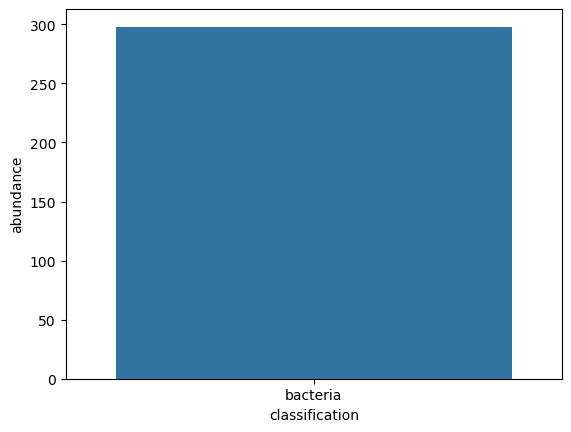

In [37]:
sns.barplot(
    y = 'abundance',
    x = 'classification',
    data = clf_onesvm,
    estimator = sum,
    ci = None,
)

<AxesSubplot:xlabel='classification', ylabel='abundance'>

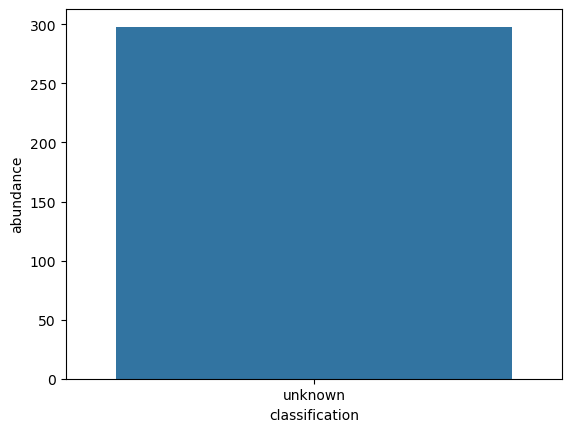

In [38]:
sns.barplot(
    y = 'abundance',
    x = 'classification',
    data = clf_widecnn,
    estimator = sum,
    ci = None,
)